In [217]:
import numpy as np
from collections import defaultdict
import copy
import time
import matplotlib.pyplot as plt

# 強化学習で実装したいもの
- 方策
    - π(a = a1|s1) = 0.3
        - 状態s1の時にa1を行う確率は0.3
        - 最終的にはこの方策が1つに決まる。(つまり100％これと言えるものを得る)
                - それがゴール
- 状態遷移確率
    - p(s = s2|s1,a = a1) = 0.6
        - 主にs = s1の時に方策の確率に従いa1の行動を実行した時にs2に映る確率を意味する。
- 報酬
    - r(s1,a,s1)
        - 主にs1からaの行動を行い,s2に移動した時に発生する報酬
- これらを用いて導き出せる漸化式がベルマン方程式
    - つまりベルマン方程式を解けば、方策が1つにきまり、最適な解が見つかる。(決定論的な方策
## 最終的に
- 方策が1意に決まり、それに基づき状態価値関数も1位に決まる。
- 今回は状態遷移確率は1とする(つまり行動が決まれば必ずその行動通りに動く)


In [218]:
# 環境の実装
class GridWorld:
    def __init__(self):

        #行動は4種類(それぞれを数字に置き換える)
        self.action_list = [0,1,2,3]
        # 辞書型で行動を紐づける
        self.action_meaning = {
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT"
        }
        # 以下にマップを作成する
        # それぞれの値はその場所の報酬を指す
        self.reward_map = np.array(
            [[0,0,0,1],
            [0,None,0,-1],
            [0,0,0,0],
            [-1,0,-1,-1],
            [0,0,0,0]]
        )
        #以下に障害物を記載し、その座標を保持
        self.goal = (0,3)
        self.start = (4,0)
        self.wall = (1,1)
        #エージェントの場所の配列を保持(スタート値で初期化)
        self.agent_state = self.start

    # 以下にメソッドを実装
    # マップの情報を取得(主に再代入不可能のgetterの役割)
    # 高さを返却
    @property
    def height(self):
        return len(self.reward_map)
    # 横幅を返却
    @property
    def width(self):
        return len(self.reward_map[0])

    #行動の種類を返却
    @property
    def actions(self):
        return self.action_list

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h,w)


    # 以下にエージェントを動かすための関数と報酬関数を実装する。
    def next_step(self,state,action):
        # 上下左右の行動をそれぞれ座標に足し合わせることで実装
        action_list = [(-1,0),(1,0),(0,-1),(0,1)]
        # 0~3までの数字を配列に入れることで行動となる数値を取得
        move = action_list[action]
        # エージェントを移動させる(moveを現在の状態の座標に足し合わせる)
        # next_state = (y座標,x座標)となる
        next_state = (state[0] + move[0],state[1] + move[1])
        new_y,new_x = next_state

        # 移動したのちそれがマップから外れてるかどうかの確認処理(外れていたら更新を中断)
        if new_x < 0 or new_x >= self.width or new_y < 0 or new_y >= self.height or next_state == self.wall:
            next_state = state
        return next_state #(2,3)みたいに次の座標
    # 報酬関数
    def reward(self,state,action,next_state):
        return self.reward_map[next_state] # 1みたいに移動先での報酬を受け取る

In [219]:
env = GridWorld()
print(env.actions)
V = {}
for state in env.states():
    V[state] = 0
    print(state)
print(V)


[0, 1, 2, 3]
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
{(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0}


# 動的計画法の実装
## 必要なこと
1. まずは状態価値関数を出力しなくてはいけない
2. それが決まることで状態行動価値関数を次に実装することができる
    - その状態行動価値関数を実装するために必要なのが反復方策評価

## 以下に動的計画法を行い状態価値関数を導きだす
- 方策はどのマスも一定で上下左右に1/4の確率で移動するため、これを辞書型配列で保持し、確率と行動の番号を紐づける
-  動的計画法を用いて更新を続けていく
- そのためには辞書型配列をまずは初期化する


In [220]:
env2 = GridWorld()
V = {}
for state in env2.states():#(0,0),(0,1)...
    V[state] = {0:0.25,1:0.25,2:0.25,3:0.25}
print(V)
for i,j in V.items():
    print([i,j])

{(0, 0): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (0, 1): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (0, 2): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (0, 3): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (1, 0): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (1, 1): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (1, 2): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (1, 3): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (2, 0): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (2, 1): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (2, 2): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (2, 3): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (3, 0): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (3, 1): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (3, 2): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (3, 3): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (4, 0): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (4, 1): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (4, 2): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, (4, 3): {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}}
[(0, 0), {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}]
[(0, 1), {0: 0.25, 1: 0.25, 2: 0

In [221]:
# 以下に動的計画法の実装関数を書く
def eval_step(pi,V,env,gamma=0.9):
    # stateで全ての座標にアクセスして価値関数を更新していく(最後までエピソードが終わった時の報酬がその場所の価値関数になる)
    for state in env.states():#(0,0),(0,1)...
        # アクセスした座標がゴールだった場合は価値関数は0なので0にする
        if state == env.goal:
            V[state] = 0
            continue
        action_probs = pi[state] #{0:0.25,1:0.25,2:0.25,3:0.25}
        new_V = 0

        # 各座標と方策を取得
        for action,action_prob in action_probs.items():# action=0 action_prob=0.25
            next_state = env.next_step(state,action)
            r = env.reward(state,action,next_state)
            # 価値関数を更新していく(動的計画法)
            new_V += action_prob * (r+gamma*V[next_state]) # <-これがベルマン方程式
        V[state] = new_V
    return V





In [222]:
# 以上の関数を繰り返し行うことで(更新する数値がある値よりも少なくなった場合)状態価値関数が決定する
def policy_eval(pi,V,env,gamma,check_value = 0.001):

    while True:
        # まずは以前使った状態価値関数を保持する(更新後と更新前で比較)
        # また参照わたしにならないように値渡しを用いて(copy)保持
        old_V = copy.copy(V)
        V = eval_step(pi,V,env,gamma)

        # 更新された量の最大値を求める
        update_value = 0
        for state in V.keys(): #state=(0,0),(0,1)...
            t = abs(V[state] - old_V[state]) # 更新した値の絶対値を保持
            update_value += t
            # 更新された値がcheck_valueより小さかったらループを抜ける
        if update_value < check_value:
            end_time = time.time() - start
            break

    return V



In [223]:
# 実際に状態価値関数を実装する
env = GridWorld()
gamma = 0.9 #割引率
pi = defaultdict(lambda: {0:0.25,1:0.25,2:0.25,3:0.25})
V = defaultdict(lambda :0)
# 新しく時間計測を指定
start = time.time()
V = policy_eval(pi,V,env,gamma)
process_time = time.time() - start
print(V)
print(process_time)

defaultdict(<function <lambda> at 0x7fe64993a160>, {(0, 0): -0.4497237522905997, (1, 0): -0.8767635718254536, (0, 1): -0.22283230286911446, (0, 2): -0.09510793716072946, (1, 2): -1.215930409302978, (0, 3): 0, (2, 0): -1.693686220134511, (2, 1): -1.7388141490081546, (1, 1): -0.9122080423709611, (2, 2): -1.9608484439762819, (1, 3): -1.0212271560549966, (2, 3): -2.301682988284246, (3, 0): -2.107294236625818, (3, 1): -2.334853561042618, (3, 2): -2.3474162060864843, (3, 3): -2.723790082547313, (4, 0): -2.1189728605164686, (4, 1): -1.9614694364186716, (4, 2): -2.30243629074953, (4, 3): -2.510697464034327})
0.00512385368347168


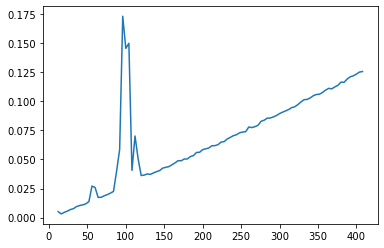

In [242]:
# ここでグラフ化
# 1. さっきまでの手順を関数化
x = list()
y = list()
tile_list =np.array(
            [[0,0,0,1],
            [0,None,0,-1],
            [0,0,0,0]]
        )


def count_time(tile_list,x,y,start):
    env = GridWorld()
    env.reward_map = tile_list
    env.start = (4+start,0)
    gamma = 0.9 #割引率
    pi = defaultdict(lambda: {0:0.25,1:0.25,2:0.25,3:0.25})
    V = defaultdict(lambda :0)
    start = time.time()
    V = policy_eval(pi,V,env,gamma)
    process_time = time.time() - start
    x.append(env.width*env.height)
    y.append(process_time)

for i in range(100):
    count_time(tile_list,x,y,i)
    tile_list = np.append(tile_list,[[0,0,-1,0]], axis=0)
plt.plot(x,y)
plt.show()

In [225]:
# ちょっとだけ綺麗に出力
X = np.zeros((env.height, env.width))
for i,j in V.items():
    a,b = i
    X[a][b] = j
print(np.array(X))


[[-0.44972375 -0.2228323  -0.09510794  0.        ]
 [-0.87676357 -0.91220804 -1.21593041 -1.02122716]
 [-1.69368622 -1.73881415 -1.96084844 -2.30168299]
 [-2.10729424 -2.33485356 -2.34741621 -2.72379008]
 [-2.11897286 -1.96146944 -2.30243629 -2.51069746]]


# 方策反復法
- 以上で各々の状態価値関数を出力することができたので、続いて方策反復法を用いて最適方策を求めていく
- 以前に導出した状態価値関数をもとに、方策を更新していき、その方策の更新で状態価値関数が更新されということを繰り返していく


In [226]:
env.states()

<generator object GridWorld.states at 0x7fe649942970>

In [227]:
# 方策を常に最大値に更新し続ける関数を作成する。
def argmax(d):
    max_value = max(d.values())
    max_key = 0
    for key,value in d.items():
        if value == max_value:
            max_key = key
    # 行動の番号を返す(つまり前後左右どの方向に動くのがいいのかの番号を返す)
    return max_key

In [228]:
# 方策反復法を用いて実装を行う
# 引数に状態価値関数,方策,割引率を受け取る
def greedy_policy(V,env,gamma):
    pi = {}
    for state in env.states():# (0, 0),(0, 1),(0, 2),(0, 3),(1, 0)...
        action_values = {}
        for action in env.actions:# [0, 1, 2, 3]
            next_state = env.next_step(state,action)
            r = env.reward(state,action,next_state)
            value = r + gamma * V[next_state]
            action_values[action] = value
        max_action = argmax(action_values)
        action_probs = {0:0,1:0,2:0,3:0}
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    return pi

In [229]:
def policy_iter(env,gamma,check_value = 0.001):
    pi = defaultdict(lambda :{0:0.25,1:0.25,2:0.25,3:0.25})
    V = defaultdict(lambda :0)

    while True:
        V = policy_eval(pi,V,env,gamma,check_value)
        new_pi = greedy_policy(V,env,gamma)

        if new_pi == pi:
            break
        pi = new_pi
    return pi


In [230]:
env = GridWorld()
gamma = 0.9
pi = policy_iter(env,gamma)

In [231]:
# 出力結果をわかりやすく出力
# [0,1,2,3]が["上","下","左","右"]に対応,また障害物,ゴールは100で表す。
def ans(pi,env):
    X = np.zeros((env.height, env.width))
    for i,j in pi.items():
        a,b = i
        if i == env.goal or i == env.wall:
            X[a][b] = None
        else:
            move = argmax(j)
            X[a][b] = move
    return X



In [232]:
ans(pi,env)
#[[0,0,0,1],
# [0,None,0,-1],
# [0,0,0,0],
# [-1,0,-1,-1],
# [0,0,0,0]]

array([[ 3.,  3.,  3., nan],
       [ 0., nan,  0.,  0.],
       [ 3.,  3.,  0.,  2.],
       [ 3.,  0.,  0.,  0.],
       [ 3.,  0.,  2.,  2.]])

In [233]:
# 動的計画法の限界を知りたい